In [ ]:
# Imports

import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, classification_report, hamming_loss
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
random.seed(42)

/Users/rodri/Desktop/MIT Fall 2024 Classes/6.8611/Project/NLP-Frameshifting/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
VALID_TOPICS = [
    'Economy and Jobs',
    'Health and Social Services',
    'Education and Innovation',
    'Environment and Energy',
    'Defense and Security',
    'Immigration and Border Policy',
    'Justice and Civil Rights',
    'Infrastructure and Transportation',
    'Budget and Fiscal Responsibility'
]

In [3]:
# Load the saved model and tokenizer
model_path = "saved_issue_model"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

print("Model and tokenizer loaded successfully!")

Model and tokenizer loaded successfully!


In [4]:
# Load the dataset
data_path = "speeches_111_gpt_topic_labels.json"
with open(data_path, "r") as f:
    data = json.load(f)

In [5]:
# Convert JSON to DataFrame
records = [
    {"speech_id": speech_id, "speech_content": details["speech"], "true_issues": details["topics"]}
    for speech_id, details in data.items()
]
df = pd.DataFrame(records)

print(f"Dataset loaded with {len(df)} speeches.")

Dataset loaded with 1807 speeches.


In [ ]:
def preprocess_data(df):
    """
    Preprocess the data by removing speeches with empty content or no labels, and removing the "Governance and Democracy" label.

    Args:
        df (pd.DataFrame): The raw dataset.

    Returns:
        pd.DataFrame: The preprocessed dataset.
    """
    # Remove speeches with only "Governance and Democracy" as their label
    df = df[df["true_issues"].apply(lambda x: x != ["Governance and Democracy"])].copy()

    df['true_issues'] = df['true_issues'].apply(
        lambda x: [topic for topic in x if topic in VALID_TOPICS]
    )

    # Remove "Governance and Democracy" from labels for remaining speeches
    df.loc[:, "true_issues"] = df["true_issues"].apply(lambda x: [topic for topic in x if topic != "Governance and Democracy"])

    df = df[df["speech_content"].notnull()].copy()  # Remove empty speeches
    df = df[df["speech_content"].str.strip() != ""].copy()  # Remove speeches with only whitespace
    df = df[df["true_issues"].apply(len) > 0].copy()  # Remove speeches with no remaining labels
    return df

In [ ]:
df = preprocess_data(df)
print(df.head())
# Print summary
print(f"Preprocessed dataset contains {len(df)} speeches.")

    speech_id  ...                                        true_issues
2  1110123245  ...                                 [Economy and Jobs]
3  1110123251  ...  [Health and Social Services, Education and Inn...
4  1110123254  ...                         [Justice and Civil Rights]
5  1110123256  ...  [Budget and Fiscal Responsibility, Economy and...
6  1110123260  ...                         [Education and Innovation]

[5 rows x 3 columns]
Preprocessed dataset contains 1445 speeches.


In [8]:
# Load unique topics from training
unique_topics_path = "unique_topics.json"
with open(unique_topics_path, "r") as f:
    unique_topics = json.load(f)

print("Loaded unique topics:", unique_topics)

Loaded unique topics: ['Agricultural Policy', 'Agriculture', 'Agriculture and Food', 'Agriculture and Food Policy', 'Agriculture and Food Security', 'Agriculture and Forestry', 'Agriculture and Rural Affairs', 'Agriculture and Rural Development', 'Budget and Fiscal Responsibility', 'Census', 'Community Development', 'Community Engagement', 'Community Service', 'Community and Civic Engagement', 'Community and Social Services', 'Culture and Arts', 'Culture and Community', 'Culture and Heritage', 'Culture and Society', 'Defense and Security', 'Disaster Relief', 'Economy and Jobs', 'Education and Innovation', 'Energy', 'Energy and Environment', 'Energy and Natural Resources', 'Environment and Energy', 'Foreign Aid', 'Foreign Policy', 'Free Speech', 'Gun Control', 'Health and Social Services', 'History and Culture', 'History and Heritage', 'Housing', 'Housing Policy', 'Housing and Community Development', 'Housing and Home Finance Agency', 'Housing and Rent Act', 'Housing and Rent Control', 

In [ ]:
def encode_topics(topics):
    """
    Encode the topics as a binary vector.

    Args:
        topics (List[str]): A list of topics.

    Returns:
        List[int]: A binary vector encoding the topics.
    """
    labels = [0] * len(VALID_TOPICS)
    for topic in topics:
        if topic in VALID_TOPICS:
            labels[VALID_TOPICS.index(topic)] = 1
    return labels

df["true_issues_binary"] = df["true_issues"].apply(encode_topics)

In [ ]:
def sample_speeches(df, n):
    """Function to sample speeches from the dataset."""
    return df.sample(n=n, random_state=42)

# Number of speeches to sample
n = 500
sampled_df = sample_speeches(df, n)

print(f"Sampled {n} speeches.")

Sampled 500 speeches.


In [ ]:
def predict_issues(model, tokenizer, speech, unique_topics, threshold=0.5):
    """
    Predict issues for a given speech.

    Args:
        model (transformers.PreTrainedModel): The trained model.
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer.
        speech (str): The speech content.
        unique_topics (List[str]): The unique topics from the training set.
        threshold (float): The threshold for binary classification.

    Returns:
        List[str]: The predicted topics.
    """
    encoding = tokenizer(
        speech,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    with torch.no_grad():
        outputs = model(**{k: v.to(model.device) for k, v in encoding.items()})
        probabilities = torch.sigmoid(outputs.logits).cpu().numpy().flatten()

    # Convert probabilities to binary predictions
    binary_predictions = (probabilities >= threshold).astype(int)
    predicted_topics = [VALID_TOPICS[i] for i, label in enumerate(binary_predictions) if label == 1]
    return predicted_topics

In [12]:
# Predict issues for the sampled speeches
sampled_df["predicted_issues"] = sampled_df["speech_content"].apply(
    lambda x: predict_issues(model, tokenizer, x, unique_topics)
)

IndexError: list index out of range

In [17]:
# Encode predicted issues as binary vectors
sampled_df["predicted_issues_binary"] = sampled_df["predicted_issues"].apply(encode_topics)

print("Predictions completed.")

Predictions completed.


In [18]:
print(sampled_df.head())

       speech_id                                     speech_content  \
640   1110033147  I would like to point out to my friend from Mi...   
916   1110120737  What we have before us today is a bill which. ...   
54    1110051690  Madam Speaker. I rise today to honor the servi...   
1718  1110134150  Madam Speaker. I rise today to introduce the "...   
161   1110002142  Madam Speaker. I rise in opposition to H.R. 2....   

                             true_issues  \
640   [Budget and Fiscal Responsibility]   
916   [Budget and Fiscal Responsibility]   
54                [Defense and Security]   
1718          [Justice and Civil Rights]   
161         [Health and Social Services]   

                                     true_issues_binary  \
640   [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...   
916   [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...   
54    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1718  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
161   [0, 0, 

In [19]:
from sklearn.metrics import hamming_loss, classification_report, accuracy_score

# Ensure true and predicted binary labels exist
true_labels = np.array(sampled_df["true_issues_binary"].tolist())
predicted_labels = np.array(sampled_df["predicted_issues_binary"].tolist())

# Evaluate Hamming Loss
hamming_loss_score = hamming_loss(true_labels, predicted_labels)
print(f"Hamming Loss: {hamming_loss_score:.4f}")

# Calculate Subset Accuracy
subset_accuracy = np.mean(np.all(true_labels == predicted_labels, axis=1))
print(f"Subset Accuracy: {subset_accuracy:.4f}")

# Calculate Overall Accuracy
overall_accuracy = accuracy_score(true_labels.flatten(), predicted_labels.flatten())
print(f"Overall Accuracy (flattened): {overall_accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_topics))


Hamming Loss: 0.0045
Subset Accuracy: 0.7240
Overall Accuracy (flattened): 0.9955

Classification Report:
                                      precision    recall  f1-score   support

                 Agricultural Policy       0.00      0.00      0.00         0
                         Agriculture       0.00      0.00      0.00         0
                Agriculture and Food       0.00      0.00      0.00         0
         Agriculture and Food Policy       0.00      0.00      0.00         0
       Agriculture and Food Security       0.00      0.00      0.00         0
            Agriculture and Forestry       0.00      0.00      0.00         0
       Agriculture and Rural Affairs       0.00      0.00      0.00         0
   Agriculture and Rural Development       0.00      0.00      0.00         0
    Budget and Fiscal Responsibility       0.92      0.70      0.79       105
                              Census       0.00      0.00      0.00         0
               Community Developmen

/Users/rodri/Desktop/MIT Fall 2024 Classes/6.8611/Project/NLP-Frameshifting/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rodri/Desktop/MIT Fall 2024 Classes/6.8611/Project/NLP-Frameshifting/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rodri/Desktop/MIT Fall 2024 Classes/6.8611/Project/NLP-Frameshifting/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels wi

<Figure size 800x600 with 0 Axes>

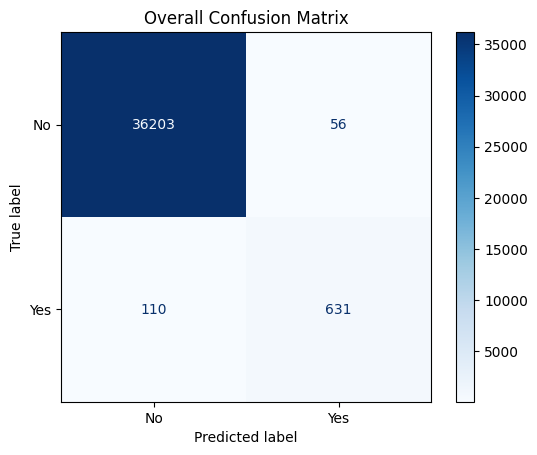

Overall Confusion Matrix (raw values):
[[36203    56]
 [  110   631]]


In [20]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrices for each label
confusion_matrices = multilabel_confusion_matrix(true_labels, predicted_labels)

# Create a combined confusion matrix
overall_confusion_matrix = np.sum(confusion_matrices, axis=0)

# Plot the overall confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(overall_confusion_matrix, display_labels=["No", "Yes"]).plot(cmap="Blues", values_format="d")
plt.title("Overall Confusion Matrix")
plt.show()

# Print the confusion matrix as raw values
print("Overall Confusion Matrix (raw values):")
print(overall_confusion_matrix)


In [ ]:
def evaluate_issue_classifier(df, n_samples=500):
    """
    Evaluate the issue classifier on sampled data
    
    Args:
        df (pd.DataFrame): The dataset.
        n_samples (int): The number of speeches to sample.

    Returns:
        Tuple[Dict[str, float], Dict[str, Dict[str, float]]]: A tuple of metrics and classification report.
    """
    # Sample speeches
    sampled_df = df.sample(n=n_samples, random_state=42)
    
    # Make predictions
    sampled_df['predicted_issues'] = sampled_df['speech_content'].apply(
        lambda x: predict_issues(model, tokenizer, x)
    )
    
    # Encode predictions and true labels using only valid topics
    sampled_df['true_issues_binary'] = sampled_df['true_issues'].apply(encode_topics)
    sampled_df['predicted_issues_binary'] = sampled_df['predicted_issues'].apply(encode_topics)
    
    # Convert to numpy arrays
    true_labels = np.array(sampled_df['true_issues_binary'].tolist())
    predicted_labels = np.array(sampled_df['predicted_issues_binary'].tolist())
    
    # Calculate metrics
    metrics = {
        'hamming_loss': hamming_loss(true_labels, predicted_labels),
        'subset_accuracy': np.mean(np.all(true_labels == predicted_labels, axis=1)),
        'overall_accuracy': accuracy_score(true_labels.flatten(), predicted_labels.flatten())
    }
    
    # Get classification report
    report = classification_report(
        true_labels, 
        predicted_labels,
        target_names=VALID_TOPICS,
        zero_division=0,
        output_dict=True
    )
    
    # Print results
    print("\nEvaluation Results:")
    print(f"Number of speeches evaluated: {n_samples}")
    print(f"\nHamming Loss: {metrics['hamming_loss']:.4f}")
    print(f"Subset Accuracy: {metrics['subset_accuracy']:.4f}")
    print(f"Overall Accuracy: {metrics['overall_accuracy']:.4f}")
    
    print("\nPer-Topic Performance:")
    for topic in VALID_TOPICS:
        topic_metrics = report[topic]
        print(f"\n{topic}:")
        print(f"  Precision: {topic_metrics['precision']:.2f}")
        print(f"  Recall: {topic_metrics['recall']:.2f}")
        print(f"  F1-score: {topic_metrics['f1-score']:.2f}")
        print(f"  Support: {topic_metrics['support']}")
    
    print("\nAggregate Scores:")
    print(f"Micro avg F1: {report['micro avg']['f1-score']:.2f}")
    print(f"Macro avg F1: {report['macro avg']['f1-score']:.2f}")
    print(f"Weighted avg F1: {report['weighted avg']['f1-score']:.2f}")
    
    return metrics, report

# evaluation
metrics, report = evaluate_issue_classifier(df, n_samples=500)

Model and tokenizer loaded successfully!
Loaded unique topics: ['Agricultural Policy', 'Agriculture', 'Agriculture and Food', 'Agriculture and Food Policy', 'Agriculture and Food Security', 'Agriculture and Forestry', 'Agriculture and Rural Affairs', 'Agriculture and Rural Development', 'Budget and Fiscal Responsibility', 'Census', 'Community Development', 'Community Engagement', 'Community Service', 'Community and Civic Engagement', 'Community and Social Services', 'Culture and Arts', 'Culture and Community', 'Culture and Heritage', 'Culture and Society', 'Defense and Security', 'Disaster Relief', 'Economy and Jobs', 'Education and Innovation', 'Energy', 'Energy and Environment', 'Energy and Natural Resources', 'Environment and Energy', 'Foreign Aid', 'Foreign Policy', 'Free Speech', 'Gun Control', 'Health and Social Services', 'History and Culture', 'History and Heritage', 'Housing', 'Housing Policy', 'Housing and Community Development', 'Housing and Home Finance Agency', 'Housing an

<Figure size 800x600 with 0 Axes>

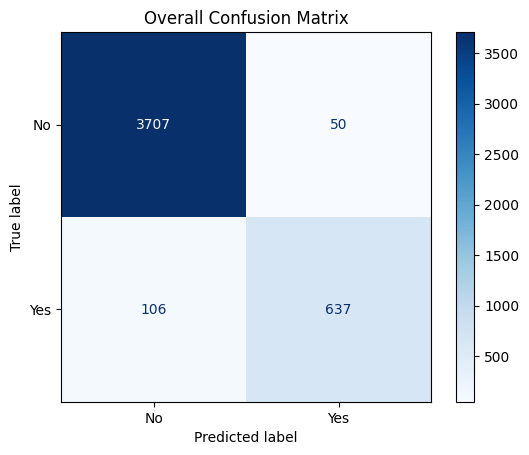

Overall Confusion Matrix (raw values):
[[3707   50]
 [ 106  637]]


In [ ]:
# Imports

import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Set random see
random.seed(42)

# Load the saved model and tokenizer
model_path = "saved_issue_model"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()
print("Model and tokenizer loaded successfully!")

# Load the dataset
data_path = "speeches_111_gpt_topic_labels.json"
with open(data_path, "r") as f:
    data = json.load(f)

# Load unique topics from training (keeping original order)
unique_topics_path = "unique_topics.json"
with open(unique_topics_path, "r") as f:
    unique_topics = json.load(f)
print("Loaded unique topics:", unique_topics)

# Define valid topics set for filtering
VALID_TOPICS = {
    'Economy and Jobs',
    'Health and Social Services',
    'Education and Innovation',
    'Environment and Energy',
    'Defense and Security',
    'Immigration and Border Policy',
    'Justice and Civil Rights',
    'Infrastructure and Transportation',
    'Budget and Fiscal Responsibility'
}

records = [
    {"speech_id": speech_id, "speech_content": details["speech"], "true_issues": details["topics"]}
    for speech_id, details in data.items()
]
df = pd.DataFrame(records)
print(f"Dataset loaded with {len(df)} speeches.")

# Preprocessing function
def preprocess_data(df):
    # Remove speeches with empty content or no valid labels
    df = df[df["speech_content"].notnull()].copy()
    df = df[df["speech_content"].str.strip() != ""].copy()
    
    # Filter to only valid topics
    df['true_issues'] = df['true_issues'].apply(
        lambda x: [topic for topic in x if topic in VALID_TOPICS]
    )
    df = df[df['true_issues'].apply(len) > 0].copy()
    
    return df

# Apply preprocessing
df = preprocess_data(df)
print(f"Preprocessed dataset contains {len(df)} speeches.")

# Encode topics for evaluation (using original unique_topics order)
def encode_topics(topics):
    labels = [0] * len(unique_topics)
    for topic in topics:
        if topic in unique_topics:  # Keep original index mapping
            labels[unique_topics.index(topic)] = 1
    return labels

df["true_issues_binary"] = df["true_issues"].apply(encode_topics)

# Function to sample speeches
def sample_speeches(df, n):
    return df.sample(n=n, random_state=42)

# Number of speeches to sample
n = 500
sampled_df = sample_speeches(df, n)
print(f"Sampled {n} speeches.")

# Predict issues for sampled speeches
def predict_issues(model, tokenizer, speech, threshold=0.5):
    encoding = tokenizer(
        speech,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    
    with torch.no_grad():
        outputs = model(**{k: v.to(model.device) for k, v in encoding.items()})
        probabilities = torch.sigmoid(outputs.logits).cpu().numpy().flatten()
        
        # Convert probabilities to binary predictions
        binary_predictions = (probabilities >= threshold).astype(int)
        predicted_topics = [unique_topics[i] for i, label in enumerate(binary_predictions) if label == 1]
        # Filter to only valid topics
        predicted_topics = [topic for topic in predicted_topics if topic in VALID_TOPICS]
        return predicted_topics

# Predict issues for the sampled speeches
sampled_df['predicted_issues'] = sampled_df['speech_content'].apply(
    lambda x: predict_issues(model, tokenizer, x)
)

# Encode predicted issues as binary vectors
sampled_df['predicted_issues_binary'] = sampled_df['predicted_issues'].apply(encode_topics)

print("Predictions completed.")

# Calculate metrics for valid topics only
true_labels = np.array(sampled_df['true_issues_binary'].tolist())
predicted_labels = np.array(sampled_df['predicted_issues_binary'].tolist())

# Get indices of valid topics
valid_indices = [i for i, topic in enumerate(unique_topics) if topic in VALID_TOPICS]

# Filter matrices to only include valid topics
true_labels = true_labels[:, valid_indices]
predicted_labels = predicted_labels[:, valid_indices]

# Evaluate Hamming Loss
hamming_loss_score = hamming_loss(true_labels, predicted_labels)
print(f"Hamming Loss: {hamming_loss_score:.4f}")

# Calculate Subset Accuracy
subset_accuracy = np.mean(np.all(true_labels == predicted_labels, axis=1))
print(f"Subset Accuracy: {subset_accuracy:.4f}")

# Calculate Overall Accuracy
overall_accuracy = accuracy_score(true_labels.flatten(), predicted_labels.flatten())
print(f"Overall Accuracy (flattened): {overall_accuracy:.4f}")

# Classification Report
valid_topic_list = list(VALID_TOPICS)
print("\nClassification Report:")
print(classification_report(
    true_labels, 
    predicted_labels,
    target_names=valid_topic_list,
    zero_division=0
))

# Generate confusion matrices
confusion_matrices = multilabel_confusion_matrix(true_labels, predicted_labels)

# Create a combined confusion matrix
overall_confusion_matrix = np.sum(confusion_matrices, axis=0)

# Plot the overall confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(overall_confusion_matrix, display_labels=['No', 'Yes']).plot(cmap='Blues', values_format='d')
plt.title('Overall Confusion Matrix')
plt.show()

# Print the confusion matrix as raw values
print("Overall Confusion Matrix (raw values):")
print(overall_confusion_matrix)